In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
class RNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_length, num_classes)
        self.dropout = nn.Dropout(0.4)  # Thêm dropout

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = out.reshape(out.shape[0], -1)
        out = self.dropout(out)  # Áp dụng dropout
        out = self.fc(out)
        return out

In [6]:
input_size = 26        # Số đặc trưng đầu vào, tương ứng với kích thước đặc trưng của mỗi bước trong chuỗi
sequence_length = 1    # Chiều dài chuỗi, mỗi chuỗi có 32 bước
num_layers = 4         # Số lớp RNN
hidden_size = 256      # Số đơn vị ẩn trong lớp RNN
num_classes = 2        # Số lớp đầu ra (cho phép phân loại 10 lớp)
learning_rate = 0.0001  # Tốc độ học
batch_size = 1024       # Kích thước của mỗi batch
epochs = 200             # Số epoch huấn luyện

In [7]:
torch.manual_seed(42)

In [8]:
X_train = pd.read_parquet('X_train.parquet')
y_train = pd.read_parquet('y_train.parquet')

X_test = pd.read_parquet('X_test.parquet')
y_test = pd.read_parquet('y_test.parquet')

In [9]:
X_train

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
2142,0.0,0.0,0.0,1.0,0.291667,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1623,0.0,0.0,0.0,0.0,0.750000,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
6074,1.0,0.0,1.0,0.0,0.013889,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1362,1.0,0.0,0.0,0.0,0.055556,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
6754,1.0,0.0,0.0,1.0,0.000000,1.0,1.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,1.0,0.0,1.0,0.0,0.013889,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5191,0.0,0.0,1.0,1.0,0.319444,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5226,1.0,0.0,1.0,1.0,0.166667,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5390,1.0,1.0,0.0,0.0,0.166667,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


<Axes: >

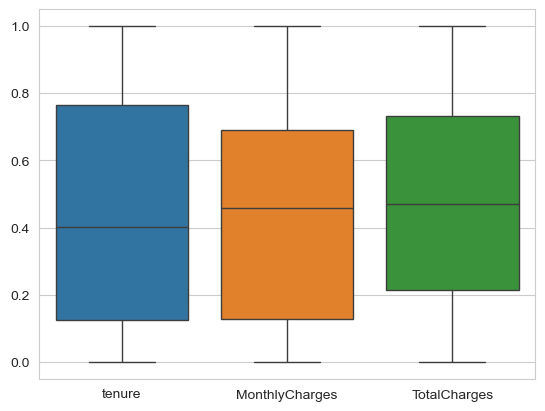

In [10]:
sns.boxplot(X_train[['tenure', 'MonthlyCharges', 'TotalCharges']])

In [11]:
cols = X_train.columns

In [12]:
# Chuyển đổi dữ liệu đã augment thành tensor
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).view(-1, sequence_length, input_size).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).view(-1).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).view(-1, sequence_length, input_size).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).view(-1).to(device)

In [13]:
# Create DataLoader for batches
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [14]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [15]:
# Khởi tạo mô hình với các hyperparameters đã được định nghĩa
model = RNN_LSTM(input_size, hidden_size, num_layers, num_classes).to(device)

In [16]:
print(model)

RNN_LSTM(
  (lstm): LSTM(26, 256, num_layers=4, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)


In [17]:
# Định nghĩa hàm mất mát CrossEntropyLoss và bộ tối ưu hóa Adam
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [18]:
# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [19]:
# Train the model
losses = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        # Forward
        scores = model(data)
        loss = criterion(scores, targets)
        epoch_loss += loss.item()

        # Backward
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)

        # Gradient descent on adam step
        optimizer.step()

    # Update learning rate
    scheduler.step()

    losses.append(epoch_loss / len(train_loader))

    # In kết quả mỗi 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss / len(train_loader):.4f}')


Epoch [10/200], Loss: 0.5044
Epoch [20/200], Loss: 0.4470
Epoch [30/200], Loss: 0.4361
Epoch [40/200], Loss: 0.4331
Epoch [50/200], Loss: 0.4270
Epoch [60/200], Loss: 0.4250
Epoch [70/200], Loss: 0.4224
Epoch [80/200], Loss: 0.4202
Epoch [90/200], Loss: 0.4192
Epoch [100/200], Loss: 0.4153
Epoch [110/200], Loss: 0.4202
Epoch [120/200], Loss: 0.4185
Epoch [130/200], Loss: 0.4205
Epoch [140/200], Loss: 0.4201
Epoch [150/200], Loss: 0.4170
Epoch [160/200], Loss: 0.4190
Epoch [170/200], Loss: 0.4181
Epoch [180/200], Loss: 0.4177
Epoch [190/200], Loss: 0.4196
Epoch [200/200], Loss: 0.4174


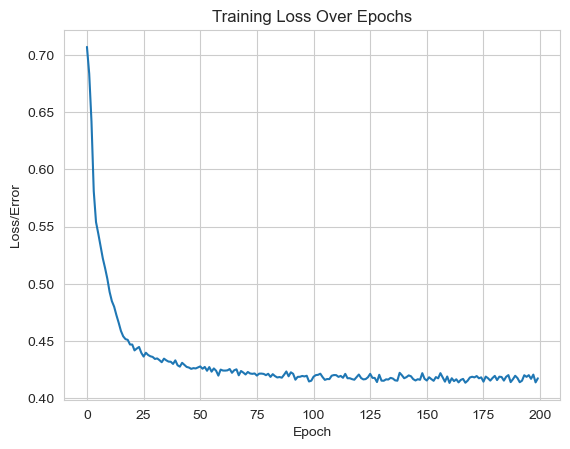

In [20]:
# Vẽ đồ thị độ mất mát qua các epochs
plt.plot(range(epochs), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss/Error')
plt.title('Training Loss Over Epochs')
plt.show()

In [21]:
# Đánh giá mô hình trên tập dữ liệu kiểm tra (validate model on test set)
model.eval()
with torch.no_grad(): # Về cơ bản tắt back propagation (tắt gradient descent)

    # Dự đoán trên tập kiểm tra
    y_eval = model.forward(X_test_tensor) # X_test_tensor là các đặc trưng từ tập kiểm tra, y_eval sẽ là các dự đoán

    # Tính độ mất mát trên tập kiểm tra
    loss = criterion(y_eval, y_test_tensor)

print(f'Test Loss: {loss.item():.4f}')

Test Loss: 0.3974


In [22]:
correct = 0
# Chuyển mô hình sang chế độ đánh giá
model.eval()
with torch.no_grad():
    for i in range(X_test_tensor.size(0)):
        y_val = model.forward(X_test_tensor[i].unsqueeze(0))  # Thêm unsqueeze(0) để thêm chiều cho dữ liệu
        if y_val.argmax().item() == y_test_tensor[i]:
            correct += 1
print(f'We got {correct}/{y_test.shape[0]}', '(',round((correct / y_test.shape[0] * 100), 2) , '% )', 'correct!')

We got 1155/1409 ( 81.97 % ) correct!


In [23]:
# Chuyển mô hình sang chế độ đánh giá
model.eval()

# Dự đoán trên tập huấn luyện và tập kiểm tra bằng mô hình Neural Network
with torch.no_grad():
    train_preds_nn = model(X_train_tensor.to(device)).cpu().numpy()
    test_preds_nn = model(X_test_tensor.to(device)).cpu().numpy()

# Kết hợp đặc trưng gốc và dự đoán của mô hình Neural Network để tạo đặc trưng mới cho các mô hình
X_train_combined = np.hstack((X_train.values, train_preds_nn))
X_test_combined = np.hstack((X_test.values, test_preds_nn))

# Huấn luyện và dự đoán với Random Forest
rf_model = RandomForestClassifier(
    n_estimators = 1000,
    max_depth = 10,
    min_samples_split = 4,
    min_samples_leaf = 2,
    max_features = 'sqrt',
    bootstrap = True,
    oob_score = True,
    random_state = 42,
    n_jobs = None
)
rf_model.fit(X_train_combined, y_train.values)
print(f'Random Forest Training Accuracy: {rf_model.score(X_train_combined, y_train.values):.4f}')
print(f'Random Forest Test Accuracy: {rf_model.score(X_test_combined, y_test.values):.4f}')

# Thêm mô hình Gradient Boosting
gb_model = GradientBoostingClassifier(
    n_estimators = 200,
    learning_rate = 0.1,
    max_depth = 3,
    min_samples_split = 2,
    min_samples_leaf = 2,
    subsample = 0.8,
    random_state = 42
)
gb_model.fit(X_train_combined, y_train.values)
print(f'Gradient Boosting Training Accuracy: {gb_model.score(X_train_combined, y_train.values):.4f}')
print(f'Gradient Boosting Test Accuracy: {gb_model.score(X_test_combined, y_test.values):.4f}')

Random Forest Training Accuracy: 0.8607
Random Forest Test Accuracy: 0.8141
Gradient Boosting Training Accuracy: 0.8477
Gradient Boosting Test Accuracy: 0.8133


In [24]:
# Hàm tính toán các chỉ số đánh giá
def churn_prediction(algo, train_x, train_y, test_x, test_y, cols, cf = 'coefficients'):
    algo.fit(train_x, train_y)
    predictions = algo.predict(test_x) # Dự đoán nhãn lớp cho tập kiểm tra test_x
    probabilities = algo.predict_proba(test_x)[:, 1] # Dự đoán xác suất cho lớp dương (rời bỏ) trên tập kiểm tra

    # Kiểm tra xem mô hình có thuộc tính 'coef_' hoặc 'feature_importances_' không
    if hasattr(algo, 'coef_') and cf == 'coefficients':
        coefficients = pd.DataFrame(algo.coef_.ravel())
    elif hasattr(algo, 'feature_importances_') and cf == 'features':
        coefficients = pd.DataFrame(algo.feature_importances_)
    else:
        coefficients = pd.DataFrame([0] * len(cols))  # Tạo một DataFrame giả nếu không có 'coef_' hoặc 'feature_importances_'

    columns_df = pd.DataFrame(cols)
    coef_sum = pd.merge(coefficients, columns_df, left_index = True, right_index = True, how = 'left')
    coef_sum.columns = ["coefficients", "features"]
    coef_sum = coef_sum.sort_values(by = 'coefficients', ascending = False)

    print(algo)
    print("\nClassification report:\n", classification_report(test_y, predictions))
    print("Accuracy Score:", accuracy_score(test_y, predictions))

    conf_matrix = confusion_matrix(test_y, predictions)
    plt.figure(figsize = (12,12))
    plt.subplot(221)
    sns.heatmap(conf_matrix, fmt = "d", annot = True, cmap = 'Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')

    model_roc_auc = roc_auc_score(test_y, probabilities)
    print("Area under curve:", model_roc_auc, "\n")
    fpr, tpr, thresholds = roc_curve(test_y, probabilities)

    churn_rate_prob = np.mean(probabilities)
    churn_rate_pred = np.mean(predictions)

    print(f"Churn rate (based on probabilities): {churn_rate_prob:.2%}")
    print(f"Churn rate (based on predictions): {churn_rate_pred:.2%}")

    plt.subplot(222)
    plt.plot(fpr, tpr, color = 'darkorange', lw = 1, label = "Auc: %.3f" % model_roc_auc)
    plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (tỉ lệ giả)')
    plt.ylabel('True Positive Rate (tỉ lệ đúng)')
    plt.title('Biểu đồ đặc trưng')
    plt.legend(loc="lower right")

    plt.subplot(212)
    sns.barplot(x = coef_sum["features"], y = coef_sum["coefficients"])
    plt.title('Feature Importances')
    plt.xticks(rotation = "vertical")

    plt.show()

RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=4,
                       n_estimators=1000, oob_score=True, random_state=42)

Classification report:
               precision    recall  f1-score   support

           0       0.85      0.91      0.88      1036
           1       0.68      0.55      0.61       373

    accuracy                           0.81      1409
   macro avg       0.77      0.73      0.75      1409
weighted avg       0.81      0.81      0.81      1409

Accuracy Score: 0.8140525195173882
Area under curve: 0.8632151396896706 

Churn rate (based on probabilities): 26.87%
Churn rate (based on predictions): 21.50%


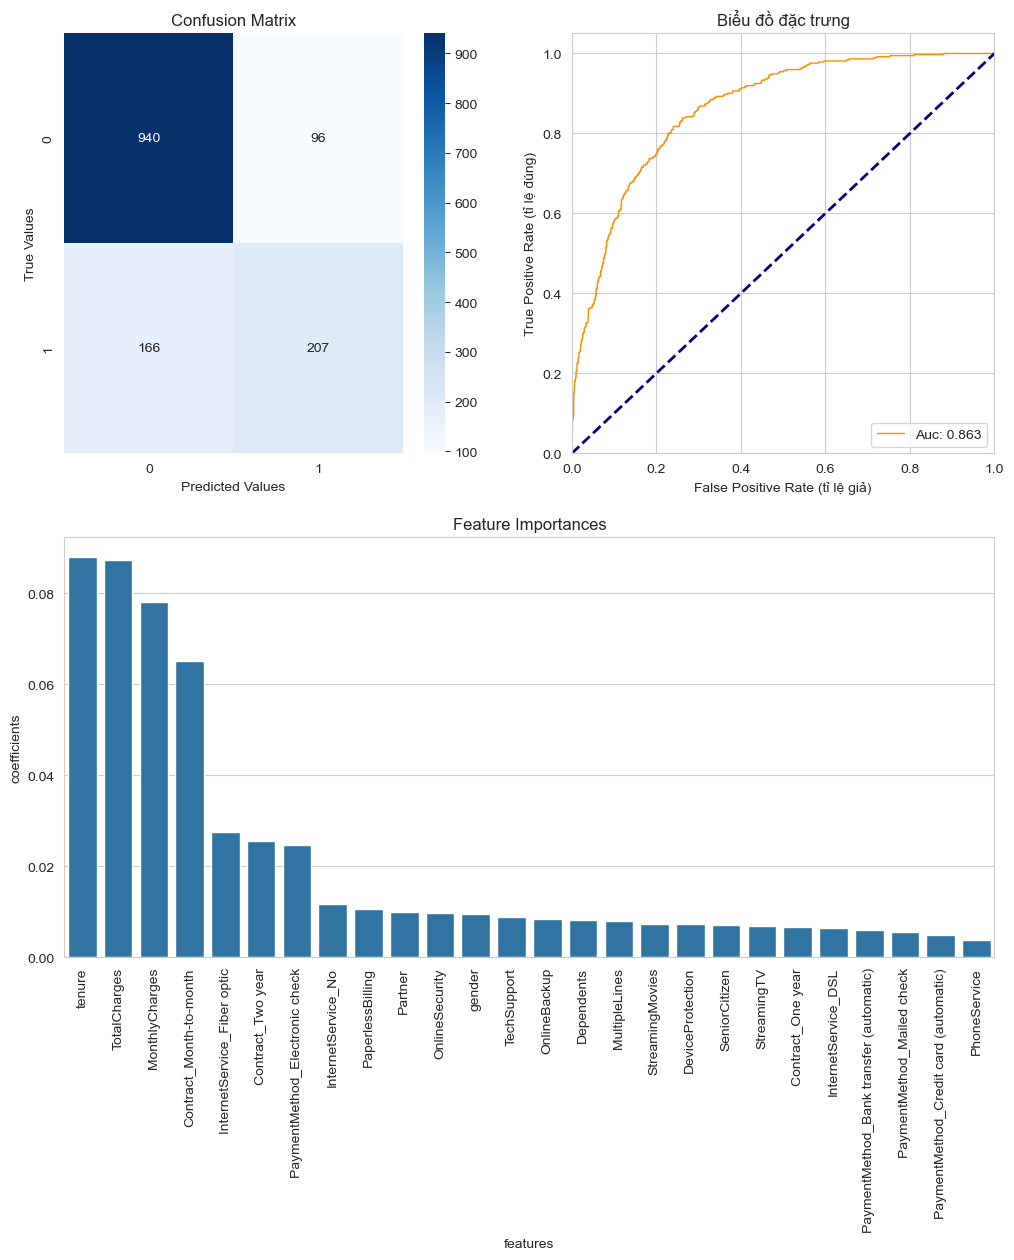

In [25]:
churn_prediction(rf_model, X_train_combined, y_train.values, X_test_combined, y_test.values, cols, cf = 'features')

Số lượng khách hàng theo xác suất rời bỏ:
0-10%: 532
10-20%: 188
20-30%: 155
30-40%: 137
40-50%: 94
50-60%: 101
60-70%: 102
70-80%: 34
80-90%: 51
90-100%: 15

Tổng số khách hàng: 1409

Phần trăm khách hàng theo xác suất rời bỏ:
0-10%: 37.76%
10-20%: 13.34%
20-30%: 11.0%
30-40%: 9.72%
40-50%: 6.67%
50-60%: 7.17%
60-70%: 7.24%
70-80%: 2.41%
80-90%: 3.62%
90-100%: 1.06%


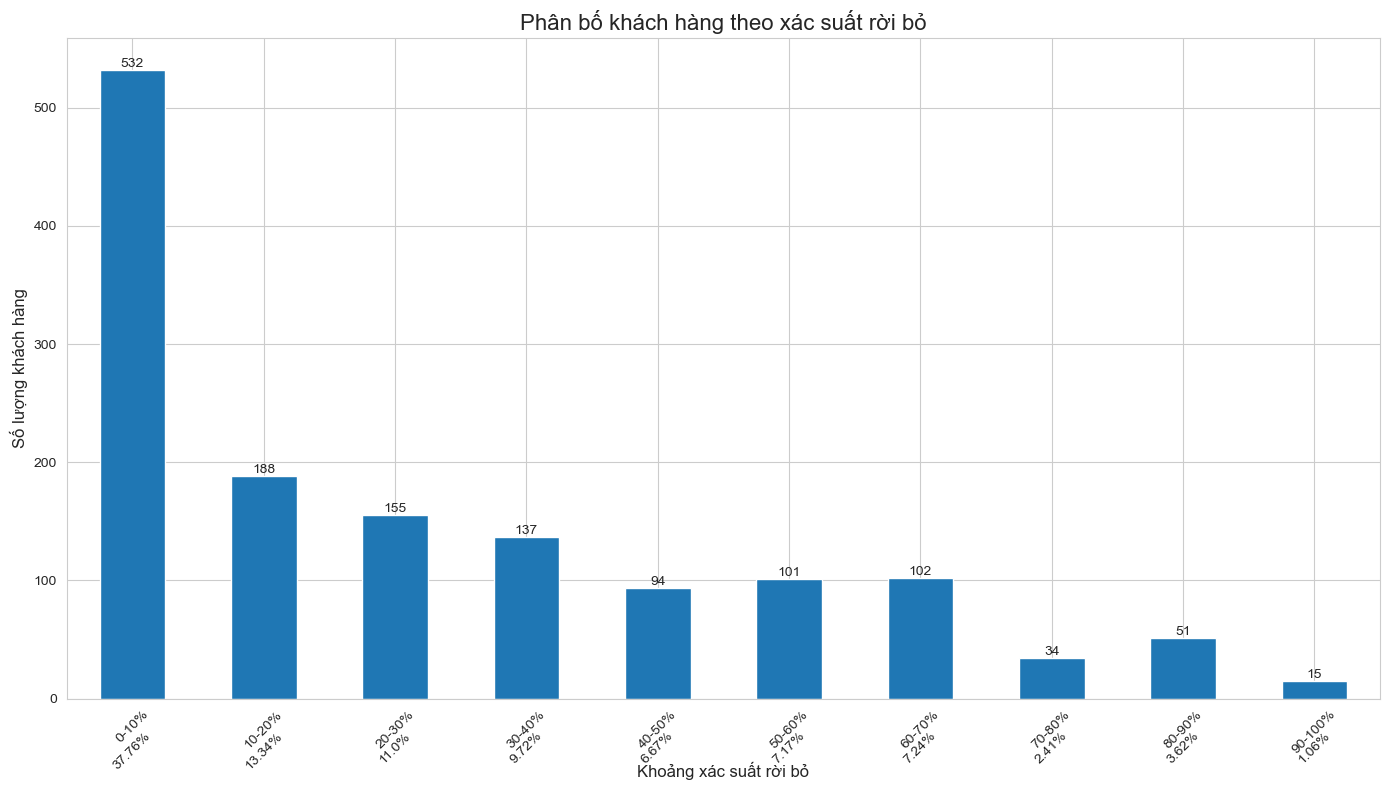

In [26]:
# Dự đoán xác suất churn cho toàn bộ dataset
probabilities = rf_model.predict_proba(X_test_combined)[:, 1]

# Tạo DataFrame chứa xác suất churn
results = pd.DataFrame({
    'churn_probability': probabilities
})

# Tạo các khoảng xác suất
bins = [i/10 for i in range(11)]  # [0.0, 0.1, 0.2, ..., 1.0]
labels = [f'{i*10}-{(i+1)*10}%' for i in range(10)]  # ['0-10%', '11-20%', ..., '91-100%']

# Phân loại xác suất vào các khoảng
results['probability_range'] = pd.cut(results['churn_probability'], bins=bins, labels=labels, include_lowest=True)

# Đếm số lượng khách hàng trong mỗi khoảng
count_by_range = results['probability_range'].value_counts().sort_index()

# In kết quả
print("Số lượng khách hàng theo xác suất rời bỏ:")
for range_label, count in count_by_range.items():
    print(f"{range_label}: {count}")

# Tính tổng số khách hàng
total_customers = len(results)
print(f"\nTổng số khách hàng: {total_customers}")

# Tính phần trăm
percentage_by_range = (count_by_range / total_customers * 100).round(2)

print("\nPhần trăm khách hàng theo xác suất rời bỏ:")
for range_label, percentage in percentage_by_range.items():
    print(f"{range_label}: {percentage}%")

# Vẽ biểu đồ
plt.figure(figsize=(14, 8))
ax = count_by_range.plot(kind='bar')
plt.title('Phân bố khách hàng theo xác suất rời bỏ', fontsize=16)
plt.xlabel('Khoảng xác suất rời bỏ', fontsize=12)
plt.ylabel('Số lượng khách hàng', fontsize=12)
plt.xticks(rotation=45)

# Thêm số lượng chi tiết trên đầu mỗi cột
for i, v in enumerate(count_by_range):
    ax.text(i, v, str(v), ha='center', va='bottom')

# Thêm phần trăm dưới nhãn trục x
for i, (range_label, percentage) in enumerate(percentage_by_range.items()):
    ax.text(i, -max(count_by_range)*0.05, f'{percentage}%', ha='center', va='top', rotation=45)

plt.tight_layout()
plt.show()